# COVID-19 Global Forecasting

This notebook will focus on forecasting the number of new cases and deaths caused by the COVID-19 virus during the month of April 2020.

The link to the competition description and data sources is the following:
https://www.kaggle.com/c/covid19-global-forecasting-week-3/data

## Data

In this notebook we'll use the Kaggle dataset with confirmed cases and fatalities by country, along with the world population dataset from the United Nations website: https://population.un.org/wpp/Download/Standard/CSV/

In [78]:
# Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.style as style
import matplotlib.pyplot as plt
import seaborn as sns
import string
import matplotlib.ticker as ticker
import re
from collections import Counter
from datetime import datetime

style.use('fivethirtyeight')
palette = "ch:-.2,2.5,dark=.3_r"

# Packages for modelling 
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler


# Interactive shell settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Reading Kaggle data
train = pd.read_csv('/Users/miketondu/Dropbox/Data Science/KAGGLE/COVID-19/covid19-global-forecasting-week-4/train.csv', 
                   date_parser='Date' )
test = pd.read_csv('/Users/miketondu/Dropbox/Data Science/KAGGLE/COVID-19/covid19-global-forecasting-week-4/test.csv',
                   date_parser='Date')
submission = pd.read_csv('/Users/miketondu/Dropbox/Data Science/KAGGLE/COVID-19/covid19-global-forecasting-week-4/submission.csv')

# Reading united nations population data
pop = pd.read_csv('/Users/miketondu/Dropbox/Data Science/KAGGLE/COVID-19/WPP2019_TotalPopulationBySex.csv')

# First look at the datasets
train.head()
test.head()
submission.head()
pop.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-04-02
1,2,NaN,Afghanistan,2020-04-03
2,3,NaN,Afghanistan,2020-04-04
3,4,NaN,Afghanistan,2020-04-05
4,5,NaN,Afghanistan,2020-04-06


,ForecastId,ConfirmedCases,Fatalities
0,1,1,1
1,2,1,1
2,3,1,1
3,4,1,1
4,5,1,1


,LocID,Location,VarID,Variant,Time,MidPeriod,PopMale,PopFemale,PopTotal,PopDensity
0,4,Afghanistan,2,Medium,1950,1950.5,4099.243,3652.874,7752.117,11.874
1,4,Afghanistan,2,Medium,1951,1951.5,4134.756,3705.395,7840.151,12.009
2,4,Afghanistan,2,Medium,1952,1952.5,4174.450,3761.546,7935.996,12.156
3,4,Afghanistan,2,Medium,1953,1953.5,4218.336,3821.348,8039.684,12.315
4,4,Afghanistan,2,Medium,1954,1954.5,4266.484,3884.832,8151.316,12.486


## Exploratory Data Analysis
Basic aggregated facts about the dataset

In [79]:
# Train data description
train[['ConfirmedCases', 'Fatalities']].describe()
train.info()
print('\n')

# Main facts
max_date = train.Date.max()
total_countries = train.Country_Region.nunique()
total_cases = train[train['Date']==max_date].ConfirmedCases.sum()
total_deaths =train[train['Date']==max_date].Fatalities.sum()

print('Max Date:', max_date)
print('Number of countries:', total_countries) 
print('Total Cases:', total_cases)
print('Total Deaths:', total_deaths)

,ConfirmedCases,Fatalities
count,25353.000000,25353.000000
mean,1003.824518,50.392853
std,7542.589521,592.843013
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,93.000000,1.000000
max,181026.000000,19468.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25353 entries, 0 to 25352
Data columns (total 6 columns):
Id                25353 non-null int64
Province_State    10773 non-null object
Country_Region    25353 non-null object
Date              25353 non-null object
ConfirmedCases    25353 non-null float64
Fatalities        25353 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.2+ MB


Max Date: 2020-04-11
Number of countries: 184
Total Cases: 1771337.0
Total Deaths: 108497.0


### Preprocessing and merging both datasets
Cleaning out names that don't match between the UN and Kaggle COVID-19 dataset such as 'Bolivia (Plurinational State of)':'Bolivia'.

In [80]:
# Replacing country names from kaggle dataset into UN dataset
pop['Location'].replace({'Venezuela (Bolivarian Republic of)':'Venezuela',
                         'United States of America': 'US',
                         'Viet Nam':'Vietnam',
                        'Bolivia (Plurinational State of)':'Bolivia'},
                       inplace=True)
# Getting 2020 population estimates from the UN, with the medium variant
pop_20 = pop[(pop['Time']==2020) & (pop['Variant']=='Medium')]
pop_20 = pop_20.groupby('Location')[['PopMale','PopFemale','PopTotal','PopDensity']].sum()


#pop_20[~pop_20.index.isin(train.Country_Region.unique())]
#train.Country_Region.unique()

In [81]:
# Merging population with train dataset
train = pd.merge(train, pop_20, left_on='Country_Region', right_on=pop_20.index ,how='left')
train.info()
train.Country_Region.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25353 entries, 0 to 25352
Data columns (total 10 columns):
Id                25353 non-null int64
Province_State    10773 non-null object
Country_Region    25353 non-null object
Date              25353 non-null object
ConfirmedCases    25353 non-null float64
Fatalities        25353 non-null float64
PopMale           23976 non-null float64
PopFemale         23976 non-null float64
PopTotal          23976 non-null float64
PopDensity        23976 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 2.1+ MB


184

In [82]:
# Create a fatalities per million column
train['fatalities_per_million'] = round(train['Fatalities']/(train['PopTotal']/1000),2)

# Countries with the most cases and fatalities ordered by date and cases 
top = (train[train['Date'] == max_date]
       .groupby(['Date','Country_Region'])[['ConfirmedCases','Fatalities','fatalities_per_million','PopTotal']]
       .sum()
       .sort_values(by=['ConfirmedCases','Fatalities'], ascending=False))

top.head(25)
top.tail(25)

ConfirmedCases  Fatalities  fatalities_per_million  \
Date       Country_Region                                                       
2020-04-11 US                    526233.0     20458.0                   61.84   
           Spain                 163027.0     16606.0                  355.17   
           Italy                 152271.0     19468.0                  321.99   
           France                130727.0     13851.0                  212.20   
           Germany               124908.0      2736.0                   32.66   
           China                  83014.0      3343.0                    2.29   
           United Kingdom         79874.0      9892.0                  145.70   
           Iran                   70029.0      4357.0                    0.00   
           Turkey                 52167.0      1101.0                   13.05   
           Belgium                28018.0      3346.0                  288.71   
           Switzerland            25107.0      1036.0                  119.70   
           Netherlands            24571.0      2653.0                  154.84   
           Canada                 23303.0       653.0                   17.31   
           Brazil                 20727.0      1124.0                    5.29   
           Portugal               15987.0       470.0                   46.09   
           Austria                13806.0       337.0                   37.42   
           Russia                 13584.0       106.0                    0.00   
           Israel                 10743.0       101.0                   11.67   
           Korea, South           10480.0       211.0                    0.00   
           Sweden                 10151.0       887.0                   87.83   
           Ireland                 8928.0       320.0                   64.81   
           India                   8446.0       288.0                    0.21   
           Ecuador                 7257.0       315.0                   17.85   
           Chile                   6927.0        73.0                    3.82   
           Peru                    6848.0       181.0                    5.49   

                               PopTotal  
Date       Country_Region                
2020-04-11 US              1.787414e+07  
           Spain           4.675478e+04  
           Italy           6.046183e+04  
           France          7.180086e+05  
           Germany         8.378395e+04  
           China           4.749768e+07  
           United Kingdom  7.467460e+05  
           Iran            0.000000e+00  
           Turkey          8.433907e+04  
           Belgium         1.158962e+04  
           Switzerland     8.654618e+03  
           Netherlands     8.567436e+04  
           Canada          4.529059e+05  
           Brazil          2.125594e+05  
           Portugal        1.019671e+04  
           Austria         9.006400e+03  
           Russia          0.000000e+00  
           Israel          8.655541e+03  
           Korea, South    0.000000e+00  
           Sweden          1.009927e+04  
           Ireland         4.937796e+03  
           India           1.380004e+06  
           Ecuador         1.764306e+04  
           Chile           1.911621e+04  
           Peru            3.297185e+04

ConfirmedCases  Fatalities  \
Date       Country_Region                                                 
2020-04-11 Belize                                      13.0         2.0   
           Botswana                                    13.0         1.0   
           Malawi                                      12.0         2.0   
           Eswatini                                    12.0         0.0   
           Saint Kitts and Nevis                       12.0         0.0   
           Saint Vincent and the Grenadines            12.0         0.0   
           Chad                                        11.0         0.0   
           Seychelles                                  11.0         0.0   
           Suriname                                    10.0         1.0   
           MS Zaandam                                   9.0         2.0   
           Gambia                                       9.0         1.0   
           Nepal                                        9.0         0.0   
           Cabo Verde                                   8.0         1.0   
           Nicaragua                                    8.0         1.0   
           Central African Republic                     8.0         0.0   
           Holy See                                     8.0         0.0   
           Sierra Leone                                 8.0         0.0   
           Mauritania                                   7.0         1.0   
           Bhutan                                       5.0         0.0   
           Burundi                                      5.0         0.0   
           Sao Tome and Principe                        4.0         0.0   
           South Sudan                                  4.0         0.0   
           Western Sahara                               4.0         0.0   
           Papua New Guinea                             2.0         0.0   
           Timor-Leste                                  2.0         0.0   

                                             fatalities_per_million   PopTotal  
Date       Country_Region                                                       
2020-04-11 Belize                                              5.03    397.621  
           Botswana                                            0.43   2351.625  
           Malawi                                              0.10  19129.955  
           Eswatini                                            0.00   1160.164  
           Saint Kitts and Nevis                               0.00     53.192  
           Saint Vincent and the Grenadines                    0.00    110.947  
           Chad                                                0.00  16425.859  
           Seychelles                                          0.00     98.340  
           Suriname                                            1.70    586.634  
           MS Zaandam                                          0.00      0.000  
           Gambia                                              0.41   2416.664  
           Nepal                                               0.00  29136.808  
           Cabo Verde                                          1.80    555.988  
           Nicaragua                                           0.15   6624.554  
           Central African Republic                            0.00   4829.764  
           Holy See                                            0.00      0.809  
           Sierra Leone                                        0.00   7976.985  
           Mauritania                                          0.22   4649.660  
           Bhutan                                              0.00    771.612  
           Burundi                                             0.00  11890.781  
           Sao Tome and Principe                               0.00    219.161  
           South Sudan                                         0.00  11193.729  
           Western Sahara                                      0.00    597.

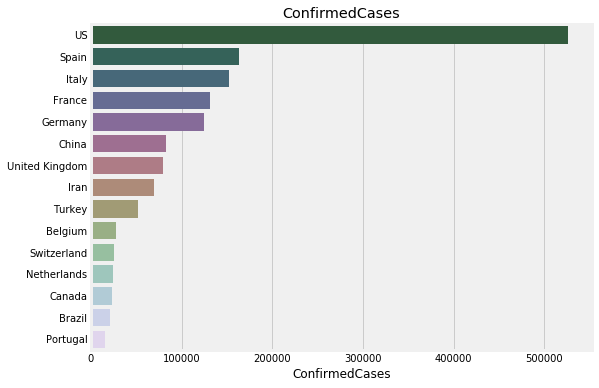

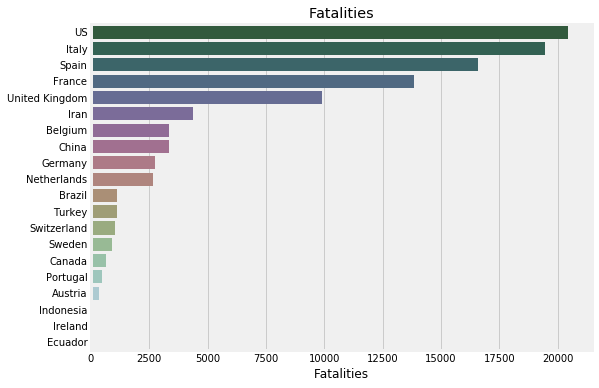

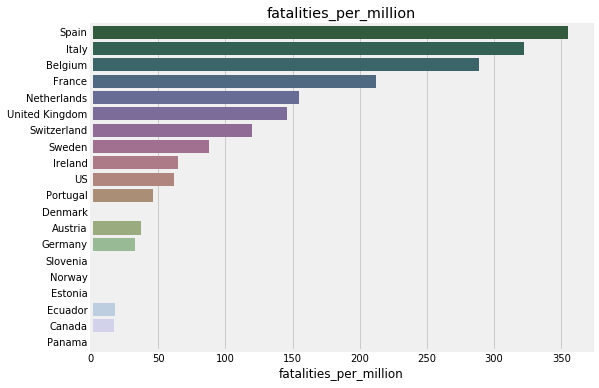

In [83]:
# Bar graph for most affected countries by cases and fatalities
def bar_graph(df, dep_var, size=15):
    fig,axes = plt.subplots(figsize=(8,6))
    sns.barplot(y =df.index.get_level_values(1)[0:size],
                x=df[dep_var][0:size], 
                palette=palette,
                order= df.sort_values(by=dep_var,ascending=False).index.get_level_values(1)[0:size])
    plt.title(dep_var)
    plt.ylabel('')
    plt.show();

bar_graph(top,'ConfirmedCases')
bar_graph(top,'Fatalities', 20)
bar_graph(top[top['PopTotal']>=1000],'fatalities_per_million', 20) # exclude countries with less than one million total population



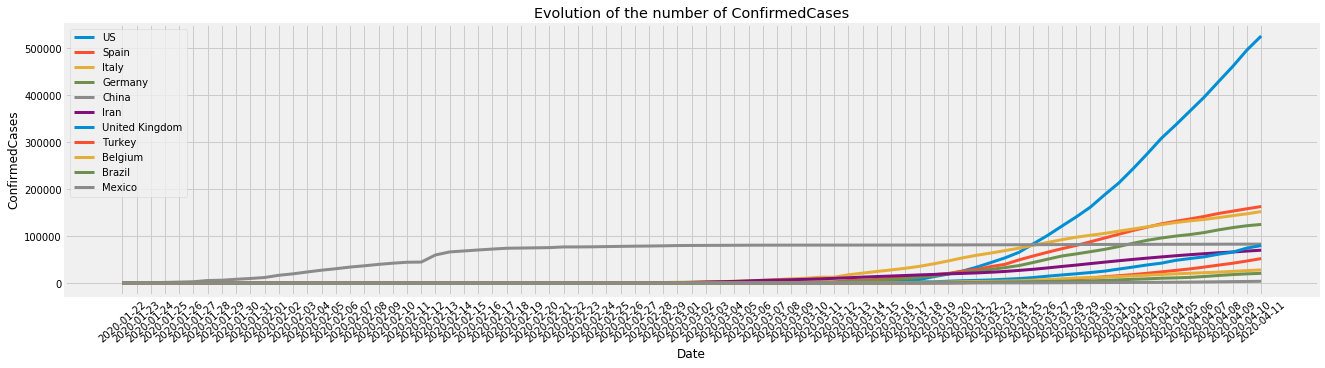

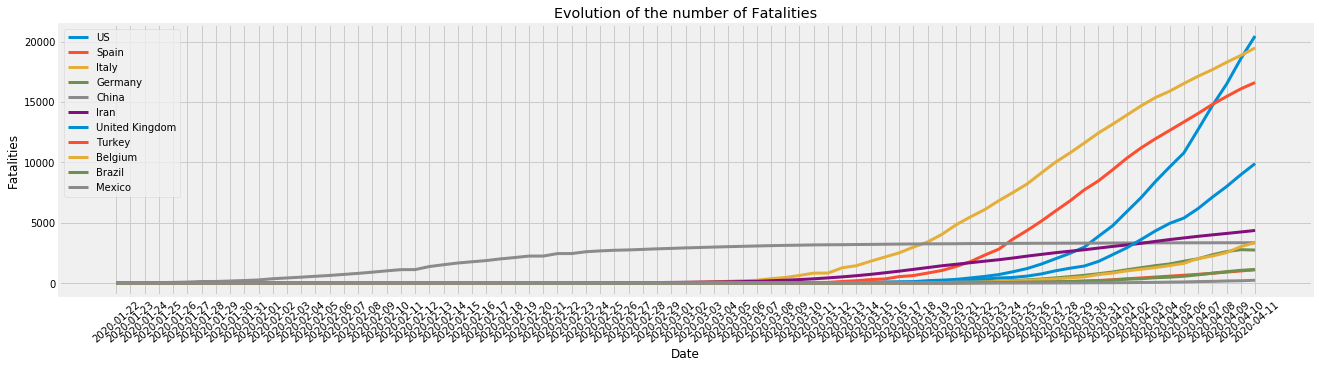

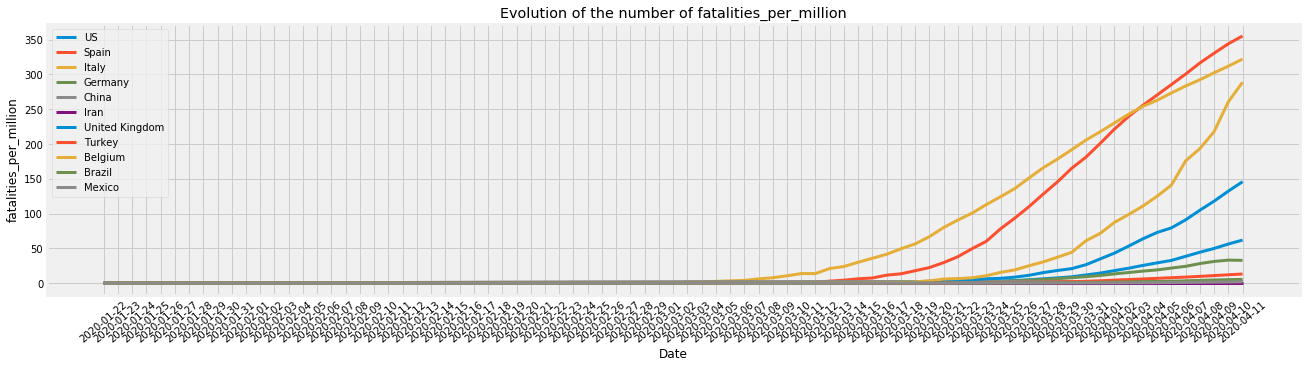

In [84]:
# Creating graphs with case count, fatality, and fatalities per million citizens trends by country
def Country_graph(df, dep_var,*argv):
    fig, axes=plt.subplots(figsize=(20,5))
    labels=argv
    for a in argv: 
        country=df.loc[(df['Country_Region']==a)]
        sns.lineplot(country['Date'],country[dep_var],linewidth=3,palette=palette)
        plt.xticks(rotation=40)
        plt.legend(labels)
        axes.set(title='Evolution of the number of ' + dep_var )

                
train_sum=train.groupby(['Date','Country_Region']).agg('sum').reset_index()

# Recorded cases
Country_graph(train_sum,'ConfirmedCases', 'US','Spain','Italy','Germany', 'China','Iran', 'United Kingdom','Turkey','Belgium','Brazil', 'Mexico')
# Fatalities
Country_graph(train_sum,'Fatalities','US','Spain','Italy','Germany', 'China','Iran', 'United Kingdom','Turkey','Belgium','Brazil', 'Mexico')  
# Fatalities per million citizens
Country_graph(train_sum,'fatalities_per_million','US','Spain','Italy','Germany', 'China','Iran', 'United Kingdom','Turkey','Belgium','Brazil', 'Mexico')       



## Training and Prediction
This section will use different algorithms to create a prediction model of the evolution of cases of COVID-19. Two separate models will be initialized and run in order to predict both target variables: 'ConfirmedCases' and 'Fatalities'. Given that the contagion and fatality curves are not linear, we will not be using a linear regressor. Instead we'll use XGBoost.

### Preprocessing
This section will apply certain transformations to the train and test datasets in order to feed them into the model.

#### Train set transformation

In [85]:
# Extracting day and month features so they can be used in the model
train["Date"] = pd.to_datetime(train["Date"])
train["Month"] = train["Date"].dt.month
train["Day"] = train["Date"].dt.day
train.drop('Date',axis=1,inplace=True)

cols = ['Province_State', 'Country_Region', 'PopMale', 'PopFemale', 'PopTotal', 'PopDensity', 
        'Month', 'Day', 'ConfirmedCases','Fatalities']
train = train[cols]

# Dealing with empty provinces by replacing nan values with country name
def province(state,country):
    if state == "nan":
        return country
    return state
train.fillna("nan",inplace=True)
train["Province_State"] = train.apply(lambda x: province(x["Province_State"],x["Country_Region"]),axis=1)

# Using sklearn's label enconder to transform string country and province values into numerical ones
def labelencoder(data):
    le = LabelEncoder()
    new_data = le.fit_transform(data)
    return new_data
train["Country_Region"] = labelencoder(train["Country_Region"].values)
train["Province_State"] = labelencoder(train["Province_State"].values)

#### The same transformations must be applied to the test data

In [86]:
# Merging test set with population data
test = pd.merge(test, pop_20, left_on='Country_Region', right_on=pop_20.index, how='left' )

# Transforming test set
test.fillna("nan",inplace=True)
test["Province_State"] = test.apply(lambda x: province(x["Province_State"],x["Country_Region"]),axis=1)
test["Country_Region"] = labelencoder(test["Country_Region"].values)
test["Province_State"] = labelencoder(test["Province_State"].values)
# Extracting day and month features so they can be used in the model
test["Date"] = pd.to_datetime(test["Date"])
test["Month"] = test["Date"].dt.month
test["Day"] = test["Date"].dt.day
test.drop('Date',axis=1,inplace=True)   
# Selecting columns
cols = ['Province_State', 'Country_Region','PopMale', 'PopFemale', 'PopTotal', 'PopDensity',
        'Month', 'Day']


,ForecastId,Province_State,Country_Region,PopMale,PopFemale,PopTotal,PopDensity,Month,Day
0,1,0,0,19976.3,18952.1,38928.3,59.627,4,2
1,2,0,0,19976.3,18952.1,38928.3,59.627,4,3
2,3,0,0,19976.3,18952.1,38928.3,59.627,4,4
3,4,0,0,19976.3,18952.1,38928.3,59.627,4,5
4,5,0,0,19976.3,18952.1,38928.3,59.627,4,6
5,6,0,0,19976.3,18952.1,38928.3,59.627,4,7
6,7,0,0,19976.3,18952.1,38928.3,59.627,4,8
7,8,0,0,19976.3,18952.1,38928.3,59.627,4,9
8,9,0,0,19976.3,18952.1,38928.3,59.627,4,10
9,10,0,0,19976.3,18952.1,38928.3,59.627,4,11


### Initializing and training predictive model

In [92]:
submission = []
# Loop and filter through all the unique countries
for country in train.Country_Region.unique():
    train1 = train[train["Country_Region"]==country]
    
    # Loop and filter through all the States of the selected country
    for state in train1.Province_State.unique():
        train2 = train1[train1["Province_State"]==state]
        
        # Convert to numpy array for training
        df_model = train2.values
        
        # Separate the features and labels
        X_train, y_train = df_model[:,:-2], df_model[:,-2:]
        
        # Model for predicting Confirmed Cases
        regressor = XGBRegressor(n_estimators=1000)
        regressor.fit(X_train, y_train[:,0])
        # model2 for predicting Fatalities
        regressor2 = XGBRegressor(n_estimators=1000)
        regressor2.fit(X_train, y_train[:,1])
       
        #Get the test data for that particular country and state
        test1 = test[(test["Country_Region"]==country) & (test["Province_State"] == state)]
        
        #Store the ForecastId separately
        ForecastId = test1.ForecastId.values
        
        #Remove the unwanted columns
        test2 = test1[cols]
        
        #Get the predictions
        y_pred1 = regressor.predict(test2.values)
        y_pred2 = regressor2.predict(test2.values)
        
        #Append the predicted values to submission list
        for i in range(len(y_pred1)):
            d = {'ForecastId':ForecastId[i], 'ConfirmedCases':y_pred1[i], 'Fatalities':y_pred2[i]}
            submission.append(d)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

In [95]:
df_submit = pd.DataFrame(submission)
df_submit.to_csv(r'submission.csv', index=False)
